In [14]:
# --- Feature Importance Notebook ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
os.chdir("/Users/gagigetsadze/Desktop/Python programs/Time_Series_Pred")
from build_features import FeatureEngineering

In [15]:
# Project Directory Setup (adjust as necessary)
project_dir = os.getcwd()
raw_data_dir = os.path.join(project_dir, "data", "raw", "1023")

In [16]:
# Load Data
def load_data(filepath):
    try:
        df = pd.read_csv(filepath)
        print(f"Successfully loaded data from: {filepath}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred loading data: {e}")
        return None

In [17]:
raw_data_dir = os.path.join("data", "raw", "1023")

sp500_companies_path = os.path.join(raw_data_dir, "sp500_companies.csv")
sp500_index_path = os.path.join(raw_data_dir, "sp500_index.csv")
sp500_stocks_path = os.path.join(raw_data_dir, "sp500_stocks.csv")

sp500_companies_df = load_data(sp500_companies_path)
sp500_index_df = load_data(sp500_index_path)
sp500_stocks_df = load_data(sp500_stocks_path)
sp500_stocks_df['Date'] = pd.to_datetime(sp500_stocks_df['Date'])

Successfully loaded data from: data/raw/1023/sp500_companies.csv
Successfully loaded data from: data/raw/1023/sp500_index.csv
Successfully loaded data from: data/raw/1023/sp500_stocks.csv


In [18]:
def preprocess_stocks_data(sp500_stocks_df):
    if sp500_stocks_df is None:
        return None
    sp500_stocks_df = sp500_stocks_df.dropna(subset=["Adj Close"])
    sp500_stocks_df = sp500_stocks_df.sort_values(by="Date").reset_index(drop=True)
    return sp500_stocks_df

In [19]:
def create_and_merge_features(sp500_stocks_df, sp500_companies_df):
    if sp500_stocks_df is None:
        return None
    feature_eng = FeatureEngineering()
    lags_to_use = [1, 7, 30]
    sp500_stocks_df = feature_eng.create_lag_features(
        sp500_stocks_df, "Adj Close", lags_to_use
    )
    windows_to_use = [7, 30, 90]
    sp500_stocks_df = feature_eng.create_rolling_features(
        sp500_stocks_df, "Adj Close", windows_to_use
    )
    sp500_stocks_df = feature_eng.create_calendar_features(sp500_stocks_df, "Date")
    sp500_stocks_df = feature_eng.merge_company_data(
        sp500_stocks_df, sp500_companies_df
    )
    return sp500_stocks_df

In [20]:
sp500_stocks_df = preprocess_stocks_data(sp500_stocks_df)
sp500_stocks_df = create_and_merge_features(sp500_stocks_df, sp500_companies_df)

Merged the stock data with company data based on Symbol column.


In [28]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

Mean Squared Error: 1037.453738143253


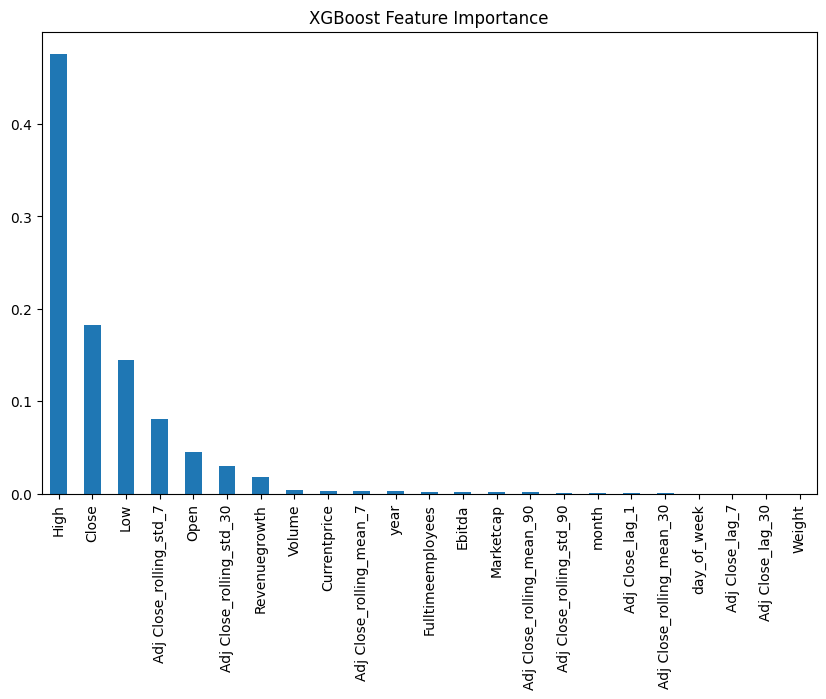

In [29]:
if sp500_stocks_df is not None:
    features = [
        col
        for col in sp500_stocks_df.columns
        if col != "Adj Close" and col != "Date"
    ]
target = 'Adj Close'
X = sp500_stocks_df[features]
X = X.select_dtypes(include=[np.number])  # Keeps only numerical columns
y = sp500_stocks_df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


feature_importance = pd.Series(xgbr.feature_importances_, index = X.columns)
feature_importance = feature_importance.sort_values(ascending = False)
plt.figure(figsize=(10,6))
feature_importance.plot(kind = 'bar')
plt.title('XGBoost Feature Importance')
plt.show()